# Import needed packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-talk')
plt.rcParams.update({'figure.dpi': 120,'figure.figsize': (6,4)})     

from pyQME.spectral_density import SpectralDensity
from pyQME.tensors.markov import RedfieldForsterTensor
from pyQME.utils import overdamped_brownian,underdamped_brownian,wn2ips,partition_by_clusters,clusterize_popt

# Define the system

**Hamiltonian (1/cm)**

In [2]:
nchrom = 3 #number of chromophores

E0 = 10000
energy_gap = 100
coupling_12 = 100
coupling_23 = 30
coupling_13 = 10
H = np.zeros((nchrom,nchrom)) #hamiltonian

H[0] = np.asarray([E0          , coupling_12     , coupling_13     ])
H[1] = np.asarray([coupling_12 , E0+energy_gap   , coupling_23     ])
H[2] = np.asarray([coupling_13 , coupling_23     , E0+2*energy_gap ])

In [3]:
with np.printoptions(suppress=True):
    print(H)

[[10000.   100.    10.]
 [  100. 10100.    30.]
 [   10.    30. 10200.]]


**Partitioning of the Hamiltonian**

Here we divide the Hamiltonian in clusters, taking into account that the first two sites are strongly coupled.

In [4]:
clusters = [[0,1],[2]]

In [5]:
H_part,V = partition_by_clusters(H,cluster_list=clusters)

In [6]:
H_part

array([[10000.,   100.,     0.],
       [  100., 10100.,     0.],
       [    0.,     0., 10200.]])

In [7]:
V

array([[ 0.,  0., 10.],
       [ 0.,  0., 30.],
       [10., 30.,  0.]])

**Temperature (Kelvin)**

Define the temperature, in Kelvin

In [8]:
temp = 298

**Spectral density**

We construct the spectral density as a sum of an overdamped and an underdamped contribution.

In [9]:
freq_axis_SD = np.arange(0.1,4000,0.1)

In [10]:
SD_data = overdamped_brownian(freq_axis_SD,30,37)
SD_data = SD_data + underdamped_brownian(freq_axis_SD,5,50,518)

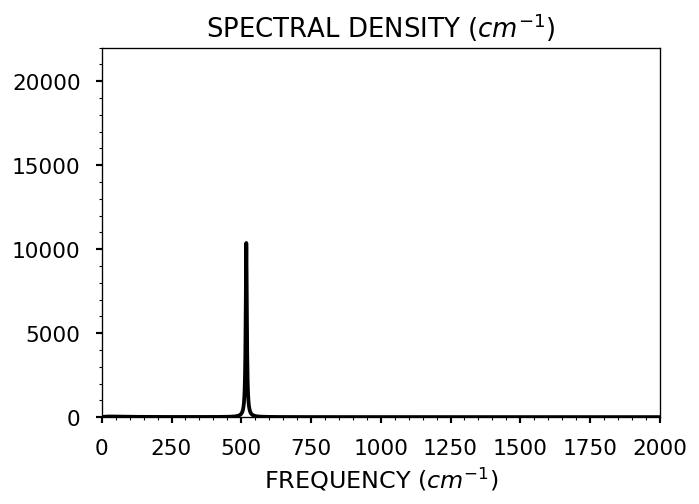

In [11]:
plt.plot(freq_axis_SD,SD_data,color='black');
plt.xlim(0,2000);
plt.ylim(0,22000)
plt.title('SPECTRAL DENSITY ($cm^{-1}$)');
plt.xlabel('FREQUENCY ($cm^{-1}$)');
plt.minorticks_on()

In [12]:
# Build the spectral density object
SD_obj = SpectralDensity(freq_axis_SD,SD_data,temperature=temp)

**Relaxation Tensor**

In [14]:
rel_tens_obj = RedfieldForsterTensor(H_part,V,SD_obj)

# Excited state dynamics

**Time axis**

In [15]:
time_axis_ps = np.arange(0,2,0.001)     #to be saved
time_axis_cm = time_axis_ps*wn2ips

**Initial density matrix**

In [16]:
#site basis
pop_0 = np.zeros([nchrom])
pop_0[1] = 1.

#convert to exciton basis
pop_0_exc = rel_tens_obj.transform_populations(pop_0)

**Propagate**

In [17]:
pop_t_exc = rel_tens_obj.propagate_rates(pop_0_exc,time_axis_cm,propagation_mode='exp_then_eig',t_switch_exp_to_eig=0.1)     #to be saved

#convert to site basis
pop_t_site = rel_tens_obj.transform_populations(pop_t_exc,inverse=True)     #to be saved

#clusterize
pop_t_cluterized = clusterize_popt(pop_t_site,clusters)     #to be saved

# Check the results

(-0.1, 0.75)

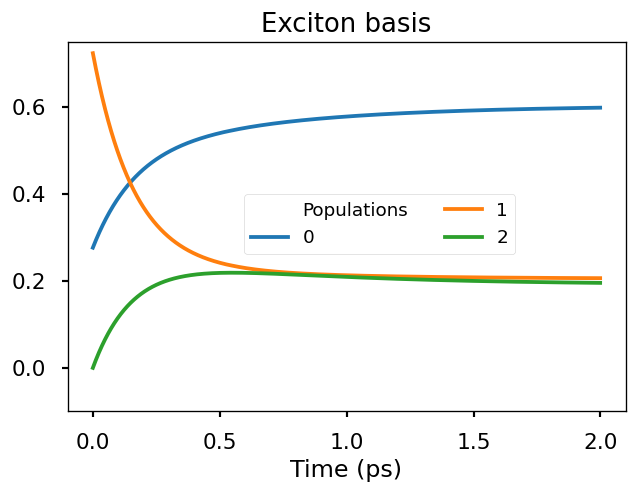

In [18]:
plt.title('Exciton basis')
plt.plot([],[],color='white',label='Populations')
plt.plot(time_axis_ps,pop_t_exc[:,0].real,label = '0')
plt.plot(time_axis_ps,pop_t_exc[:,1].real,label = '1')
plt.plot(time_axis_ps,pop_t_exc[:,2].real,label = '2')
plt.legend(ncol=2,fontsize = 11,bbox_to_anchor = (0.3,0.4))
plt.xlabel('Time (ps)');
plt.ylim(-0.1,0.75)

(-0.2, 1.0)

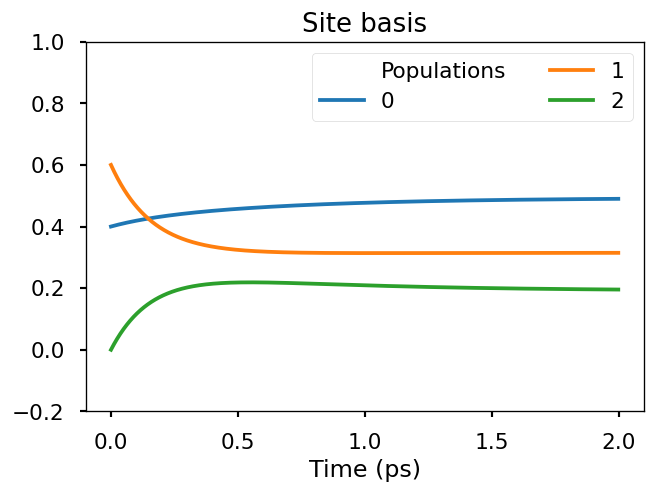

In [19]:
plt.title('Site basis')
plt.plot([],[],color='white',label='Populations')
plt.plot(time_axis_ps,pop_t_site[:,0].real,label = '0')
plt.plot(time_axis_ps,pop_t_site[:,1].real,label = '1')
plt.plot(time_axis_ps,pop_t_site[:,2].real,label = '2')
plt.legend(ncol=2,fontsize = 13)
plt.xlabel('Time (ps)');
plt.ylim(-0.2,1.0)

Text(0, 0.5, 'Populations')

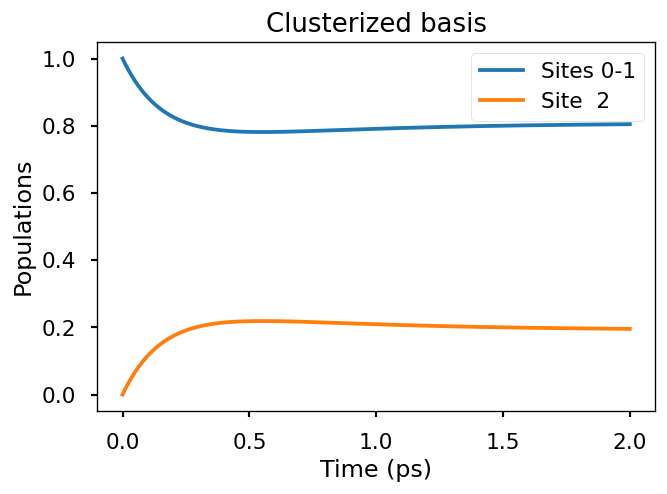

In [20]:
plt.title('Clusterized basis')
plt.plot(time_axis_ps,pop_t_cluterized[:,0].real,label = 'Sites 0-1')
plt.plot(time_axis_ps,pop_t_cluterized[:,1].real,label = 'Site  2')
plt.legend(fontsize = 13)
plt.xlabel('Time (ps)');
plt.ylabel('Populations')